In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_331441/1026082369.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v1'
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
F_BETA = 0.5
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-5
SAVE_PATH = '/mnt/data01/communav'

In [5]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT id, title, text, category_id
    FROM {TABLE_NAME}
    WHERE category_id IS NOT NULL
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 3638 articles.


In [6]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 1, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9}
{'id': 3, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 4, 'title': '전공수업듣는데', 'text': '복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'category_id': 4}
{'id': 5, 'title': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요?', 'text': '9시 넘어야 갈수있을거 같은데\n열어 있을지..', 'category_id': 7}
{'id': 8, 'title': '문화유목시대 교재뭔가요', 'text': '정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'category_id': 6}
{'id': 13, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....', 'category_id': 5}
{'id': 14, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....\n이건 회로인데 뭐가 잘못된거지요????;;', 'category_id': 5}
{'id': 17, 'title': '컴퓨터구조 책삽니다', 'text': '표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다\nPatterson , Hennessy 저자 입니다', 'category_

In [7]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [8]:
# 데이터 전처리

preprocessed_articles = []

for article in tqdm(original_articles):
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ')

    preprocessed_articles.append({
        'content': preprocess(content),
        'label': article['category_id']
    })

100%|██████████| 3638/3638 [00:00<00:00, 20469.46it/s]


In [9]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!', 'label': 9}
{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '전공수업듣는데 복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'label': 4}
{'content': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..', 'label': 7}
{'content': '문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'label': 6}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....', 'label': 5}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;', 'label': 5}
{'content': '컴퓨터구조 책삽니다 표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다 Patterson , Hennessy 저자 입니다', 'label': 5}
{'content': '오늘 영화의 이해 수업 영화의 이해 유양근 교수님 수업을 못가서 그런데 혹시 교재같은거나 해오라고 하신거 있나요?! ㅜㅜ', 'label': 6}
{'content': '초급일본어 전유나 초급일본어 책필요한가요?', 'label': 6}
{'content': '졸업학점있잖아 교양 30 전공 60 선택50 이면 무조건 저거

In [10]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} ({category_id}): {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 (0): 10.25%
학사 (1): 7.39%
장학 · 행정 (2): 23.94%
학교생활 (3): 8.25%
수업 (4): 3.46%
수업/이과 (5): 9.21%
수업/문과 (6): 5.44%
캠퍼스 (7): 5.55%
취업 · 진로 (8): 3.93%
일상생활 (9): 6.93%
음식점 · 카페 (10): 4.59%
취미 · 여가 (11): 4.01%
인간관계 (12): 2.83%
병역 (13): 4.21%


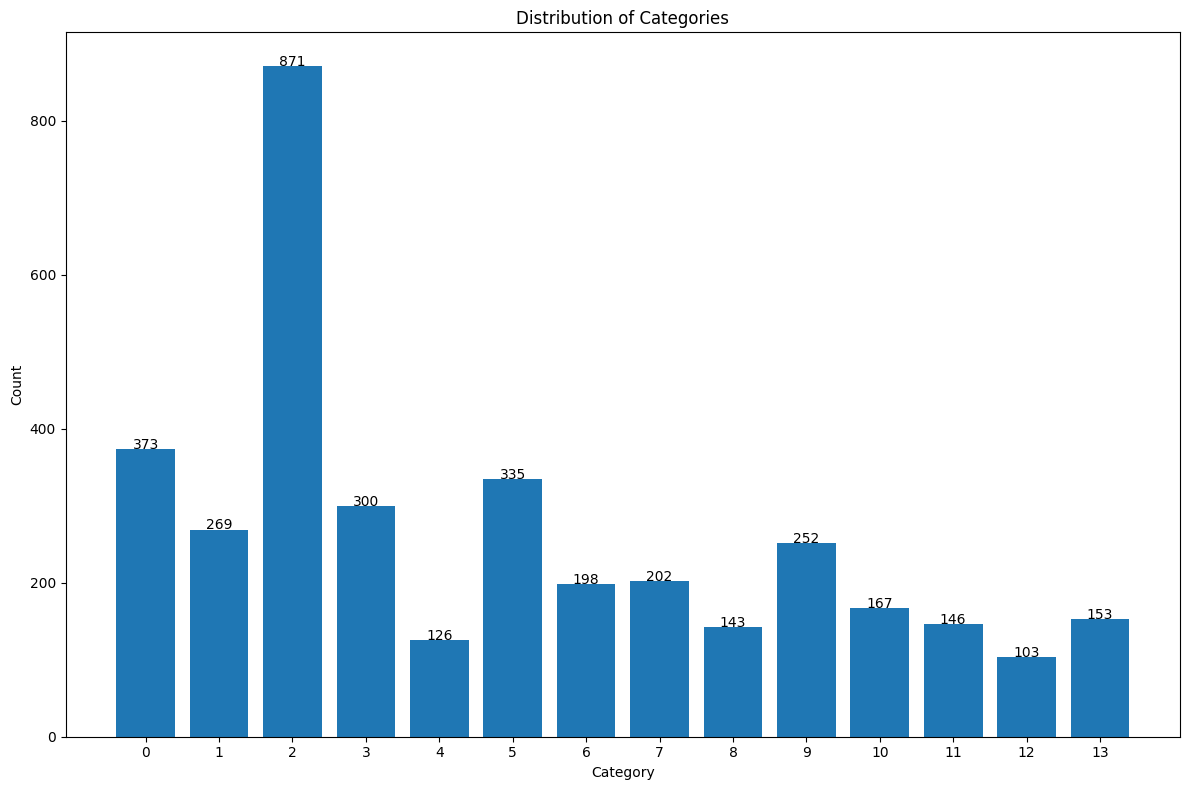

In [11]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [12]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 2910
Number of validation articles: 728


자유 (0): 10.07%
학사 (1): 7.59%
장학 · 행정 (2): 24.67%
학교생활 (3): 8.01%
수업 (4): 3.51%
수업/이과 (5): 9.11%
수업/문과 (6): 5.40%
캠퍼스 (7): 5.09%
취업 · 진로 (8): 3.71%
일상생활 (9): 6.84%
음식점 · 카페 (10): 4.71%
취미 · 여가 (11): 4.23%
인간관계 (12): 2.68%
병역 (13): 4.40%


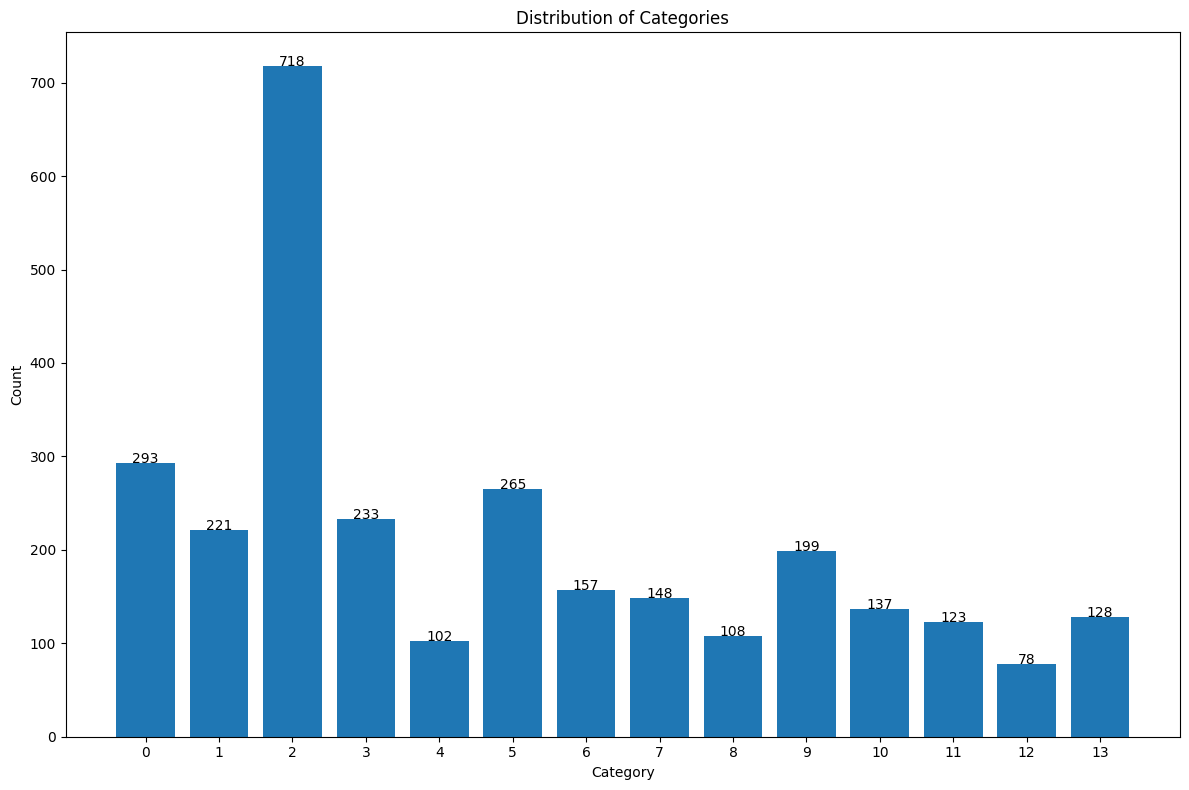

In [13]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 (0): 10.99%
학사 (1): 6.59%
장학 · 행정 (2): 21.02%
학교생활 (3): 9.20%
수업 (4): 3.30%
수업/이과 (5): 9.62%
수업/문과 (6): 5.63%
캠퍼스 (7): 7.42%
취업 · 진로 (8): 4.81%
일상생활 (9): 7.28%
음식점 · 카페 (10): 4.12%
취미 · 여가 (11): 3.16%
인간관계 (12): 3.43%
병역 (13): 3.43%


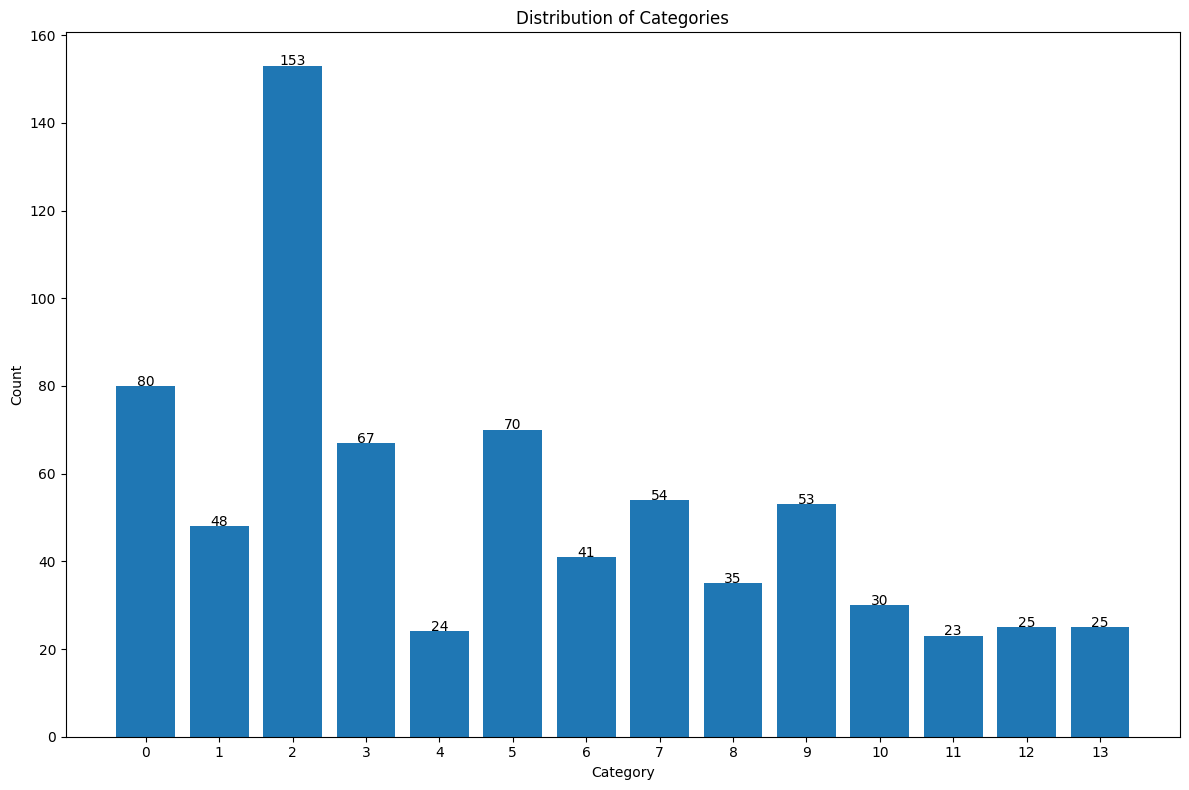

In [14]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [15]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, do_basic_tokenize=False)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [16]:
# 모델 로드

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [17]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_331441/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_331441/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_331441/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_331441/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [18]:
# 학습 전 초기화

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_accs = []
train_precs = []
train_recs = []
train_f_betas = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f_betas = []
val_losses = []

In [19]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f_beta = fbeta_score(true_labels, predicted_labels, beta=F_BETA, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f_beta

In [20]:
# 학습 시작

best_val_f_beta = 0.9
best_model_path = None

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f_beta = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f_betas.append(train_f_beta)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f_beta = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f_betas.append(val_f_beta)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F-Beta = {train_f_beta:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F-Beta = {val_f_beta:.4f}, Val Loss = {val_loss:.4f}')

    if val_f_beta > best_val_f_beta:
        best_val_f_beta = val_f_beta
        best_model_path = os.path.join(SAVE_PATH, f'model-epoch-{epoch + 1:02d}-{best_val_f_beta:.4f}')
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f'  Best model saved with {best_val_f_beta:.4f} F-beta score.')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]


Epoch 1:
  Train Acc = 0.2691, Train Prec = 0.1642, Train Rec = 0.2691, Train F-Beta = 0.1426, Train Loss = 2.3520
  Val Acc = 0.4148, Val Prec = 0.3508, Val Rec = 0.4148, Val F-Beta = 0.2574, Val Loss = 1.9412


Epoch 2 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


Epoch 2:
  Train Acc = 0.6045, Train Prec = 0.6019, Train Rec = 0.6045, Train F-Beta = 0.5087, Train Loss = 1.4400
  Val Acc = 0.6923, Val Prec = 0.6129, Val Rec = 0.6923, Val F-Beta = 0.5977, Val Loss = 1.0424


Epoch 3 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]


Epoch 3:
  Train Acc = 0.8354, Train Prec = 0.8620, Train Rec = 0.8354, Train F-Beta = 0.8268, Train Loss = 0.7577
  Val Acc = 0.8997, Val Prec = 0.9215, Val Rec = 0.8997, Val F-Beta = 0.9082, Val Loss = 0.5345
  Best model saved with 0.9082 F-beta score.


Epoch 4 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


Epoch 4:
  Train Acc = 0.9625, Train Prec = 0.9636, Train Rec = 0.9625, Train F-Beta = 0.9629, Train Loss = 0.3468
  Val Acc = 0.9396, Val Prec = 0.9416, Val Rec = 0.9396, Val F-Beta = 0.9407, Val Loss = 0.2927
  Best model saved with 0.9407 F-beta score.


Epoch 5 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


Epoch 5:
  Train Acc = 0.9835, Train Prec = 0.9836, Train Rec = 0.9835, Train F-Beta = 0.9835, Train Loss = 0.1671
  Val Acc = 0.9519, Val Prec = 0.9533, Val Rec = 0.9519, Val F-Beta = 0.9525, Val Loss = 0.2316
  Best model saved with 0.9525 F-beta score.


Epoch 6 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.71it/s]


Epoch 6:
  Train Acc = 0.9887, Train Prec = 0.9887, Train Rec = 0.9887, Train F-Beta = 0.9887, Train Loss = 0.0989
  Val Acc = 0.9464, Val Prec = 0.9499, Val Rec = 0.9464, Val F-Beta = 0.9484, Val Loss = 0.2317


Epoch 7 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.71it/s]


Epoch 7:
  Train Acc = 0.9948, Train Prec = 0.9949, Train Rec = 0.9948, Train F-Beta = 0.9949, Train Loss = 0.0628
  Val Acc = 0.9615, Val Prec = 0.9621, Val Rec = 0.9615, Val F-Beta = 0.9618, Val Loss = 0.2073
  Best model saved with 0.9618 F-beta score.


Epoch 8 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]


Epoch 8:
  Train Acc = 0.9938, Train Prec = 0.9939, Train Rec = 0.9938, Train F-Beta = 0.9938, Train Loss = 0.0500
  Val Acc = 0.9478, Val Prec = 0.9516, Val Rec = 0.9478, Val F-Beta = 0.9498, Val Loss = 0.2363


Epoch 9 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]


Epoch 9:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F-Beta = 0.9952, Train Loss = 0.0341
  Val Acc = 0.9602, Val Prec = 0.9608, Val Rec = 0.9602, Val F-Beta = 0.9604, Val Loss = 0.1951


Epoch 10 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.62it/s]


Epoch 10:
  Train Acc = 0.9959, Train Prec = 0.9959, Train Rec = 0.9959, Train F-Beta = 0.9959, Train Loss = 0.0301
  Val Acc = 0.9657, Val Prec = 0.9662, Val Rec = 0.9657, Val F-Beta = 0.9659, Val Loss = 0.1829
  Best model saved with 0.9659 F-beta score.


Epoch 11 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.63it/s]


Epoch 11:
  Train Acc = 0.9931, Train Prec = 0.9932, Train Rec = 0.9931, Train F-Beta = 0.9932, Train Loss = 0.0346
  Val Acc = 0.9505, Val Prec = 0.9531, Val Rec = 0.9505, Val F-Beta = 0.9520, Val Loss = 0.2138


Epoch 12 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.62it/s]


Epoch 12:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F-Beta = 0.9955, Train Loss = 0.0239
  Val Acc = 0.9574, Val Prec = 0.9608, Val Rec = 0.9574, Val F-Beta = 0.9593, Val Loss = 0.2400


Epoch 13 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.60it/s]


Epoch 13:
  Train Acc = 0.9993, Train Prec = 0.9993, Train Rec = 0.9993, Train F-Beta = 0.9993, Train Loss = 0.0124
  Val Acc = 0.9588, Val Prec = 0.9601, Val Rec = 0.9588, Val F-Beta = 0.9595, Val Loss = 0.1985


Epoch 14 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.60it/s]


Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0081
  Val Acc = 0.9602, Val Prec = 0.9609, Val Rec = 0.9602, Val F-Beta = 0.9606, Val Loss = 0.2081


Epoch 15 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.61it/s]


Epoch 15:
  Train Acc = 0.9993, Train Prec = 0.9993, Train Rec = 0.9993, Train F-Beta = 0.9993, Train Loss = 0.0075
  Val Acc = 0.9560, Val Prec = 0.9567, Val Rec = 0.9560, Val F-Beta = 0.9563, Val Loss = 0.2141


Epoch 16 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.60it/s]


Epoch 16:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0078
  Val Acc = 0.9615, Val Prec = 0.9623, Val Rec = 0.9615, Val F-Beta = 0.9619, Val Loss = 0.2158


Epoch 17 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0125
  Val Acc = 0.9313, Val Prec = 0.9368, Val Rec = 0.9313, Val F-Beta = 0.9334, Val Loss = 0.3845


Epoch 18 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


Epoch 18:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0260
  Val Acc = 0.9629, Val Prec = 0.9633, Val Rec = 0.9629, Val F-Beta = 0.9630, Val Loss = 0.2207


Epoch 19 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


Epoch 19:
  Train Acc = 0.9935, Train Prec = 0.9935, Train Rec = 0.9935, Train F-Beta = 0.9935, Train Loss = 0.0302
  Val Acc = 0.9602, Val Prec = 0.9610, Val Rec = 0.9602, Val F-Beta = 0.9605, Val Loss = 0.2125


Epoch 20 - Validation: 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]

Epoch 20:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0366
  Val Acc = 0.9615, Val Prec = 0.9622, Val Rec = 0.9615, Val F-Beta = 0.9617, Val Loss = 0.2298
Training finished.


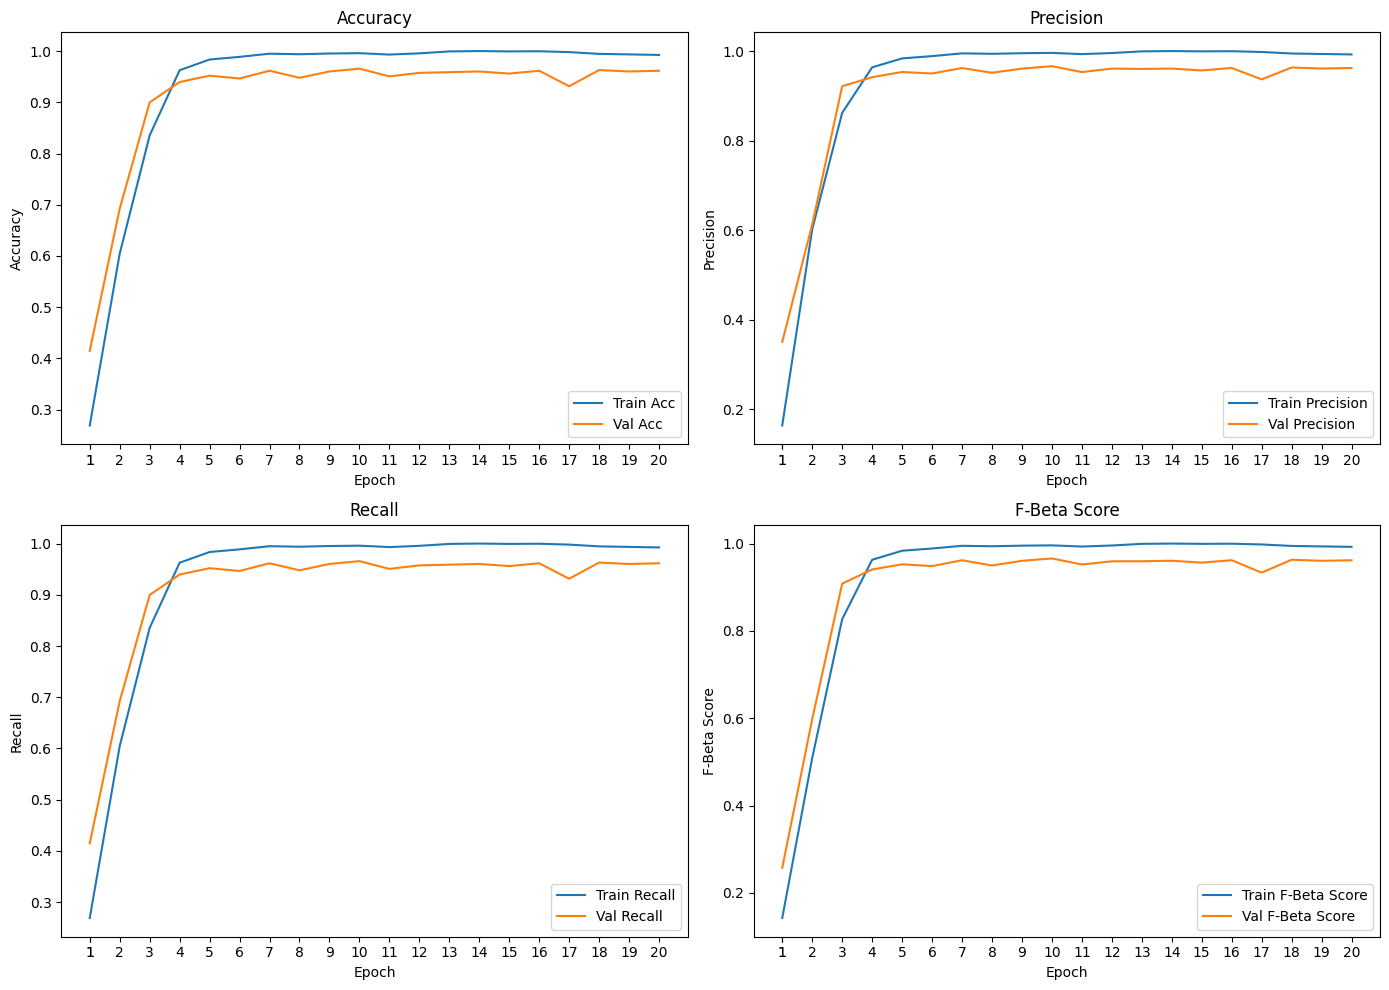

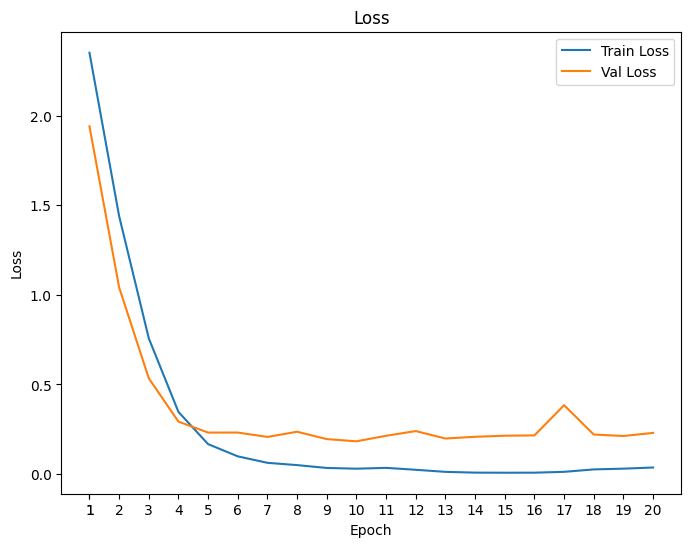

In [21]:
# 학습 결과 시각화

if EPOCHS <= 20:
    step = 1
elif EPOCHS <= 50:
    step = 5
elif EPOCHS <= 100:
    step = 10
else:
    step = 20

epochs = range(1, EPOCHS + 1)
tick_marks = [1] + list(range(step, EPOCHS + 1, step))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precs, label='Train Precision')
plt.plot(epochs, val_precs, label='Val Precision')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recs, label='Train Recall')
plt.plot(epochs, val_recs, label='Val Recall')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f_betas, label='Train F-Beta Score')
plt.plot(epochs, val_f_betas, label='Val F-Beta Score')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('F-Beta Score')
plt.legend()
plt.title('F-Beta Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [22]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS)
model.to(device)

test_articles = [
    {'content': '진단서 감기가 너무심해서 수업못가고 병원가려는데 진단서가져가면 교수님이 출석인정 해주시나요?', 'label': 1},
    {'content': '교비근로 해보신분 어떤가요?', 'label': 2},
    {'content': '나 아직 고학번이라고 할정도는 아닌데 군대갔다왔으면 졸업못한게 당연한 나이니까 화석은 아님 아무튼 아님', 'label': 0},
    {'content': '왜 가기싫은 학교에 가야하지? 왜냐면 가기싫은 직장에 다니기 위해서!', 'label': 0},
    {'content': '화공 새내기들은 뭔죄냐 이러려고 광대왔나 자괴감들고 괴로울듯 상식적으로 엠티간다고 가산점 주는게 말이되나', 'label': 3},
    {'content': '이제 병결은 출석처리 안되죠..? 모든수업', 'label': 1},
    {'content': '과거에는 학교에 국정원 온적도 있답니다. 안심하고 공부하세요 ^^', 'label': 0},
    {'content': '광운대근처찜질방 추천좀', 'label': 7},
    {'content': '피시방들 얼마에요? 쓰리팝이나 파란 간판 거기 등등 그리고 역쪽에는 600원짜리 있던데 롤 제대로 돌아가요?', 'label': 7},
    {'content': '현대사 열옸나요? 복사할게있는데!', 'label': 7},
    {'content': '컴소 2학년 이산듣는사람 ㅡㅡ', 'label': 5},
    {'content': '500m산 서울 근방에 해발 500m산이 있나여??웰니스 과제해야돼서ㅠㅠ전 강동구쪽 살고있음', 'label': 9},
    {'content': '임산부칸 여자는 그냥 앉아도 되는부분인거냐', 'label': 9},
    {'content': '책 인쇄가 이상하네요ㅠㅠ 알라딘에서 해외원서 구입에다가 이미 3글자써서 교환은 물건너갔네요ㅠㅠ', 'label': 9},
    {'content': '출튀하는법 새내기 시도할려합니다 어케해요', 'label': 3},
    {'content': '출튀 많이 했는데 과제 점수 손해본 사람 있음?', 'label': 4},
    {'content': '형들 노트북추천좀해줘요 컴맹이라;;; 용도는 문서+간단한게임(던파 롤 피파같은거)', 'label': 9},
    {'content': '남자 몇주에 한번씩 미용실가냐 한달마다 가는데 돈아까워서 두달 버텨보려함 만 이천원ㅅㅂ 개아까워', 'label': 9},
    {'content': '매점에서 컴싸랑 화이트 파나요?? 급함ㅠ', 'label': 9 },
    {'content': '국민은행위에 모텔있는거 다들 암? 그 베스킨라빈스쯤 있는 건물에 와 난 학교 바로 앞에 저런게 있을 줄 몰랐다ㅋㅋㅋㅋ', 'label': 7},
    {'content': '공차알바생 싸가지 여자알바생 ㅈㄴ 싸가지 없다 표정 개썩창이네', 'label': 10},
    {'content': '이석준 교수님 경영통계 프린트 어디서 뽑아요...? 이석준 교수님 경영통계 프린트 어디서 뽑나요...? 중간중간에 괄호쳐진 수업자료 있다고 뽑아오라고 하신것 같은데...', 'label': 6},
    {'content': 'cdp16번 채우며몇학점줘요?? 알려주세요ㅠ', 'label': 1},
    {'content': '자바공부할건데 목표를 안드로이드로 갈까 웹서버로 갈까 자격증 ocjp 로 갈까', 'label': 8},
    {'content': '한글파일 작성하고 doc파일로 저장했는데 doc파일 들어가면 파일이 깨진건지 형식이 바뀐건지 이상하게 나오는데 왜이런거죠?', 'label': 9},
    {'content': '제본하는데 오래걸리나요? 책이 너무 두꺼워서 내일 제본하려는데 1교시끝나고 3교시수업전에 될려나요', 'label': 9},
    {'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7},
    {'content': '인강50오프라인50인강의에서 인강은 유캠에서 듣는거 맞나요? 교수님한데 여쭤보니 잘 모르겠다고 하시고...온라인컨텐츠학습?들어가보니 아직 인강이 안떠있어서요', 'label': 4},
    {'content': '과씨씨말고 다른과씨씨들 어케만났냐ㅋㅋㅋ', 'label': 12},
    {'content': '금공강은진리다 진짜 와보니까알앗는데 공강전날은 너무행복하다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ', 'label': 3},
    {'content': '온라인 강의 안되는 사람...? 학습시간만 가고 흰 화면만 떠 검사할거 다 해봤는데도 안되는 것 같다', 'label': 4},
    {'content': '님들은 문제풀이 과제할때 문제 씀안씀? 문제 번호만??', 'label': 4},
    {'content': '책 인쇄가 이상하네요ㅠㅠ 알라딘에서 해외원서 구입에다가 이미 3글자써서 교환은 물건너갔네요ㅠㅠ', 'label': 9},
    {'content': '보고서에 학교마크 말그림 넣어야함 아니면 K모양 넣어야함?', 'label': 4},
]

test_contents = [preprocess(article['content']) for article in test_articles]
test_labels = [article['label'] for article in test_articles]

test_encodings = tokenizer(
    test_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
test_input_ids = test_encodings['input_ids'].to(device)
test_attention_mask = test_encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    logits = outputs.logits
    test_predictions = torch.argmax(logits, dim=1).tolist()
    test_probabilities = torch.softmax(logits, dim=1).tolist()

test_acc, test_prec, test_rec, test_f_beta = calculate_metrics(test_labels, test_predictions)

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_prec:.4f}')
print(f'Test Recall: {test_rec:.4f}')
print(f'Test F-beta Score: {test_f_beta:.4f}')
print()

for content, label, prediction, probs in zip(test_contents, test_labels, test_predictions, test_probabilities):
    true_category = CATEGORIES[label]
    predicted_category = CATEGORIES[prediction]
    probs_formatted = [f"{prob:.4f}" for prob in probs]

    print(f'텍스트: {content}')
    print(f'실제 레이블: {true_category}')
    print(f'예측 레이블: {predicted_category} {probs_formatted}')
    print()

Best model path: /mnt/data01/communav/model-epoch-10-0.9659

Test Accuracy: 0.6765
Test Precision: 0.7492
Test Recall: 0.6765
Test F-beta Score: 0.7113

텍스트: 진단서 감기가 너무심해서 수업못가고 병원가려는데 진단서가져가면 교수님이 출석인정 해주시나요?
실제 레이블: 학사
예측 레이블: 장학 · 행정 ['0.0035', '0.0101', '0.9757', '0.0005', '0.0008', '0.0006', '0.0011', '0.0005', '0.0015', '0.0019', '0.0004', '0.0003', '0.0006', '0.0027']

텍스트: 교비근로 해보신분 어떤가요?
실제 레이블: 장학 · 행정
예측 레이블: 장학 · 행정 ['0.0003', '0.0003', '0.9977', '0.0004', '0.0001', '0.0001', '0.0002', '0.0001', '0.0001', '0.0002', '0.0001', '0.0001', '0.0001', '0.0002']

텍스트: 나 아직 고학번이라고 할정도는 아닌데 군대갔다왔으면 졸업못한게 당연한 나이니까 화석은 아님 아무튼 아님
실제 레이블: 자유
예측 레이블: 병역 ['0.0066', '0.0017', '0.0008', '0.0002', '0.0060', '0.0009', '0.0014', '0.0003', '0.1236', '0.0031', '0.0004', '0.0025', '0.0069', '0.8455']

텍스트: 왜 가기싫은 학교에 가야하지? 왜냐면 가기싫은 직장에 다니기 위해서!
실제 레이블: 자유
예측 레이블: 자유 ['0.8754', '0.0005', '0.0018', '0.0222', '0.0110', '0.0039', '0.0030', '0.0021', '0.0196', '0.0025', '0.0038', '0.0277', '0.0210', '0